# Qwen3-VL Attention Extraction for Spatial Reasoning

This notebook extracts **cross-attention** from Qwen3-VL-4B-Instruct to understand how the model attends to image regions when reasoning about spatial relations.

**Key Difference from CLIP:**
- CLIP: Only self-attention (no text → image interaction)
- Qwen3-VL: Has cross-attention where text tokens attend to image patches

**What we'll extract:**
1. Vision encoder self-attention (image patches attending to each other)
2. **Cross-attention** (text tokens attending to image patches) ← Most important!
3. Language model self-attention (text attending to text + image)

In [45]:
!nvidia-smi

import sys
sys.path.append('../..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

from dataset_zoo.aro_datasets import get_controlled_images_b, get_controlled_images_a
from mechanistic.utils.visualization import (
    plot_attention_heatmap, 
    plot_attention_on_image,
    plot_cross_attention_attribution
)
from mechanistic.utils.hooks import AttentionCache
from mechanistic.utils.metrics import attention_entropy, attention_concentration

%matplotlib inline
%load_ext autoreload
%autoreload 2

Mon Oct 20 12:14:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM-64GB           On  | 00000000:56:00.0 Off |                    0 |
| N/A   44C    P0              79W / 476W |  31126MiB / 65536MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Load Qwen3-VL Model

We'll load the model with `output_attentions=True` to get attention weights.

In [2]:
# Model path (update if needed)
model_path = "/leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct"

print(f"Loading Qwen3-VL from: {model_path}")

# Load model
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager"
    # output_attentions=True  # This needs to be set during forward pass
)

# Load processor
processor = AutoProcessor.from_pretrained(model_path)

print(f"Model loaded successfully")
print(f"Device: {model.device}")

Loading Qwen3-VL from: /leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully
Device: cuda:0


## Step 2: Load Sample from Controlled Images B

In [15]:
import random

# Load dataset
dataset = get_controlled_images_b(
    image_preprocess=None,
    download=False,
    root_dir='/leonardo_work/EUHPC_D27_102/compmech/whatsup_vlms_data'
)

print(f"Dataset size: {len(dataset)}")

# Get a sample
sample_idx = 0
sample = dataset[sample_idx]

# Extract caption and objects
caption = sample['caption_options'][0]
words = caption.split()
object1 = words[1]
object2 = words[-1]

print(f"\nSample {sample_idx}:")
print(f"Caption: {caption}")
print(f"Object 1: {object1}")
print(f"Object 2: {object2}")

# Display image
image = sample['image_options'][0]
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Sample Image\n{caption}")
plt.axis('off')
plt.show()

Dataset size: 408


## Step 3: Create Prompt in Qwen Format

In [4]:
# Create question
question = f"Where is the {object1} in relation to the {object2}? Answer with left, right, front or behind."
print(f"Question: {question}")

# Prepare messages in Qwen format
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question},
        ],
    }
]

# Apply chat template
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
print(f"\nFormatted prompt (first 200 chars):\n{text[:200]}...")

Question: Where is the mug in relation to the knife? Answer with left, right, front or behind.

Formatted prompt (first 200 chars):
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Where is the mug in relation to the knife? Answer with left, right, front or behind.<|im_end|>
<|im_start|>assistant
...


## Step 4: Process Input and Extract Attention

**Important:** Qwen-VL processes images into vision tokens that get concatenated with text tokens. We need to:
1. Identify which tokens are image tokens
2. Extract attention from text tokens to image tokens (cross-attention pattern)

In [5]:
# Process inputs directly with processor (no qwen_vl_utils needed)
inputs = processor(
    text=[text],
    images=[image],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

print(f"Input shape: {inputs['input_ids'].shape}")
print(f"Total tokens: {inputs['input_ids'].shape[1]}")

# Decode tokens to see the sequence
tokens = processor.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f"\nFirst 20 tokens: {tokens[:20]}")
print(f"Last 20 tokens: {tokens[-20:]}")

Input shape: torch.Size([1, 1230])
Total tokens: 1230

First 20 tokens: ['<|im_start|>', 'user', 'Ċ', '<|vision_start|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>']
Last 20 tokens: ['Ġrelation', 'Ġto', 'Ġthe', 'Ġknife', '?', 'ĠAnswer', 'Ġwith', 'Ġleft', ',', 'Ġright', ',', 'Ġfront', 'Ġor', 'Ġbehind', '.', '<|im_end|>', 'Ċ', '<|im_start|>', 'assistant', 'Ċ']


## Step 5: Forward Pass with Attention Output

In [34]:
# Forward pass with attention
with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True,
        return_dict=True
    )

print(f"Output keys: {outputs.keys()}")

# Get attentions
if hasattr(outputs, 'attentions') and outputs.attentions is not None:
    attentions = outputs.attentions
    print(f"\nNumber of layers with attention: {len(attentions)}")
    print(f"Attention shape (first layer): {attentions[0].shape}")
    print(f"Format: [batch, heads, seq_len, seq_len]")
else:
    print("\nWarning: No attention weights found in outputs!")
    print("This might mean the model doesn't support output_attentions or we need a different approach.")

Output keys: odict_keys(['logits', 'past_key_values', 'rope_deltas', 'attentions'])

Number of layers with attention: 36
Attention shape (first layer): torch.Size([1, 32, 1230, 1230])
Format: [batch, heads, seq_len, seq_len]


## Step 6: Identify Image vs Text Tokens

Qwen-VL uses special tokens to mark image regions. We need to identify:
- `<|vision_start|>` and `<|vision_end|>` markers
- Image patch tokens between these markers

In [35]:
# Find image token positions
token_ids = inputs['input_ids'][0]
tokens_list = [processor.tokenizer.decode(t) for t in token_ids]

# Look for vision markers
vision_start_token = "<|vision_start|>"
vision_end_token = "<|vision_end|>"
image_pad_token = "<|image_pad|>"

# Find indices
vision_start_idx = None
vision_end_idx = None

for i, token in enumerate(tokens_list):
    if vision_start_token in token:
        vision_start_idx = i
    if vision_end_token in token:
        vision_end_idx = i
        break

if vision_start_idx and vision_end_idx:
    print(f"Image tokens span: [{vision_start_idx}, {vision_end_idx}]")
    print(f"Number of image tokens: {vision_end_idx - vision_start_idx - 1}")
    
    # Calculate grid size (assuming square patches)
    num_image_tokens = vision_end_idx - vision_start_idx - 1
    grid_size = int(np.sqrt(num_image_tokens))
    print(f"Image grid size: {grid_size}x{grid_size}")
else:
    print("Could not find vision tokens!")
    print(f"Tokens: {tokens_list}")

Image tokens span: [3, 1204]
Number of image tokens: 1200
Image grid size: 34x34


In [36]:
if attentions and vision_start_idx and vision_end_idx:
    # Get last layer attention
    last_layer_attn = attentions[18]  # [batch, heads, seq, seq]
    
    # Average over heads
    avg_attn = last_layer_attn[0].mean(0)  # [seq, seq]
    
    # Extract cross-attention: text tokens → image tokens
    # Text tokens are after vision_end_idx
    text_start_idx = vision_end_idx + 1
    
    # Attention from text to image patches
    cross_attn = avg_attn[text_start_idx:, vision_start_idx+1:vision_end_idx]
    
    print(f"Cross-attention shape: {cross_attn.shape}")
    print(f"Format: [num_text_tokens, num_image_patches]")
    
    # Get text tokens for labeling
    text_tokens = tokens_list[text_start_idx:]
    print(f"\nText tokens: {text_tokens[:20]}...")  # First 20 text tokens
else:
    print("Cannot extract cross-attention - missing attention or vision token indices")

Cross-attention shape: torch.Size([25, 1200])
Format: [num_text_tokens, num_image_patches]

Text tokens: ['Where', ' is', ' the', ' mug', ' in', ' relation', ' to', ' the', ' book', '?', ' Answer', ' with', ' left', ',', ' right', ',', ' front', ' or', ' behind', '.']...


## Step 8: Visualize Cross-Attention for Key Words

Let's find spatial words (left, right, front, behind) and object names in the text, then visualize where they attend.

Found 7 interesting tokens: ['Where(0)', ' mug(3)', ' book(8)', ' left(12)', ' right(14)', ' front(16)', ' behind(18)']


NameError: name 'grid_height' is not defined

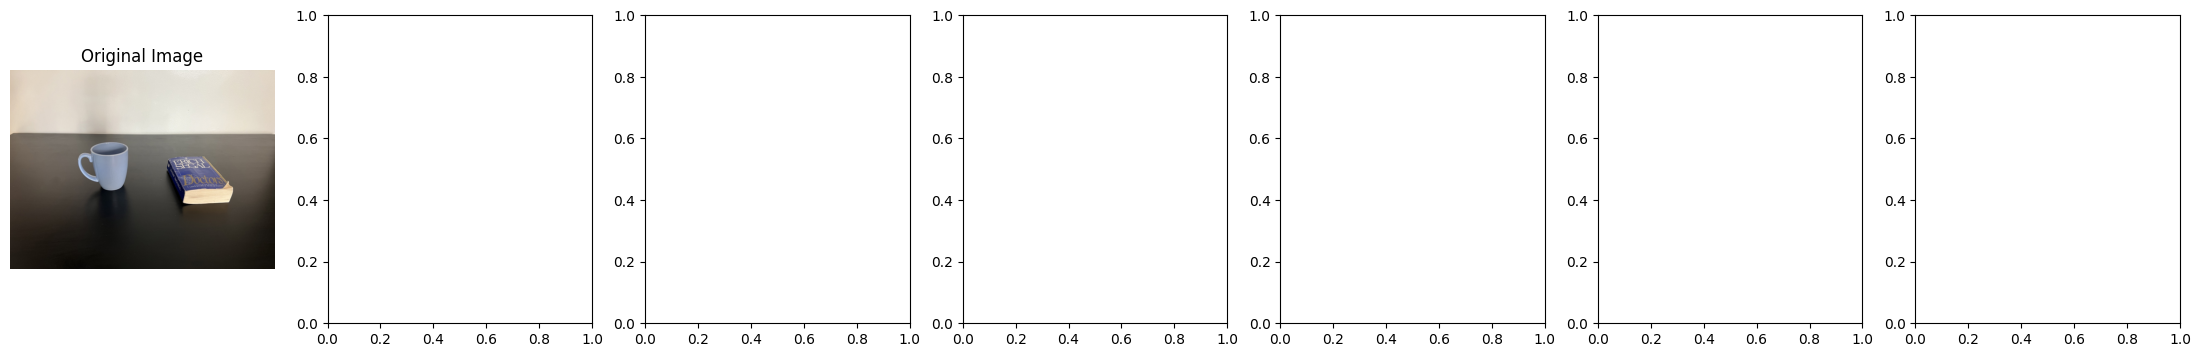

In [37]:
if 'cross_attn' in locals():
    # Find indices of interesting tokens
    spatial_words = ['left', 'right', 'front', 'behind', 'where']
    object_words = [object1.lower(), object2.lower()]
    interesting_words = spatial_words + object_words
    
    interesting_indices = []
    interesting_labels = []
    
    for i, token in enumerate(text_tokens):
        token_clean = token.strip().lower()
        for word in interesting_words:
            if word in token_clean:
                interesting_indices.append(i)
                interesting_labels.append(f"{token}({i})")
                break
    
    print(f"Found {len(interesting_indices)} interesting tokens: {interesting_labels}")
    
    if len(interesting_indices) > 0:
        # Plot attention for each interesting token
        n_tokens = min(len(interesting_indices), 6)  # Max 6 tokens
        fig, axes = plt.subplots(1, n_tokens + 1, figsize=(4 * (n_tokens + 1), 4))
        
        # Plot original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Plot attention for each token
        for plot_idx, token_idx in enumerate(interesting_indices[:n_tokens]):
            token_attn = cross_attn[token_idx]  # [num_image_patches]
            
            # Reshape to 2D grid
            attn_grid = token_attn.cpu().float().reshape(grid_height, grid_width).numpy()
            
            # Normalize
            attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min() + 1e-8)
            
            # Resize to image size
            from scipy.ndimage import zoom
            img_array = np.array(image)
            zoom_factor = (img_array.shape[0] / grid_size, img_array.shape[1] / grid_size)
            attn_resized = zoom(attn_grid, zoom_factor, order=1)
            
            # Plot
            axes[plot_idx + 1].imshow(img_array)
            axes[plot_idx + 1].imshow(attn_resized, cmap='hot', alpha=0.6)
            axes[plot_idx + 1].set_title(f'Token: {interesting_labels[plot_idx]}')
            axes[plot_idx + 1].axis('off')
        
        plt.suptitle(f'Cross-Attention: Text Tokens → Image Patches\n{caption}', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("No interesting tokens found in text!")

## Step 9: Aggregate Attention for Spatial Words

In [38]:
if 'cross_attn' in locals() and len(interesting_indices) > 0:
    # Get attention for spatial words only
    spatial_token_indices = []
    for i, token in enumerate(text_tokens):
        if any(word in token.lower() for word in spatial_words):
            spatial_token_indices.append(i)

    if len(spatial_token_indices) > 0:
        # Average attention across all spatial tokens
        spatial_attn = cross_attn[spatial_token_indices].mean(0)  # [num_image_patches]
        
        # Reshape and visualize
        attn_grid = spatial_attn.cpu().float().reshape(grid_height, grid_width).numpy()
        attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min() + 1e-8)
        
        # Resize
        from scipy.ndimage import zoom
        img_array = np.array(image)
        zoom_factor = (img_array.shape[0] / grid_height, img_array.shape[1] / grid_width)
        attn_resized = zoom(attn_grid, zoom_factor, order=1)
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        ax2.imshow(img_array)
        im = ax2.imshow(attn_resized, cmap='hot', alpha=0.6)
        ax2.set_title('Averaged Spatial Word Attention')
        ax2.axis('off')
        
        plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
        plt.suptitle(f'Where does the model look for spatial reasoning?\n{caption}', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("No spatial words found in text!")

NameError: name 'grid_height' is not defined

## Step 10: Analyze Attention Metrics

In [ ]:
if 'cross_attn' in locals():
    # Calculate metrics for cross-attention
    entropy = attention_entropy(cross_attn, dim=-1)
    concentration = attention_concentration(cross_attn, k=5)
    
    print(f"Cross-Attention Metrics:")
    print(f"  Average entropy: {entropy.mean():.3f} (lower = more focused)")
    print(f"  Average top-5 concentration: {concentration.mean():.3f} (higher = more concentrated)")
    
    # Plot distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.hist(entropy.cpu().float().numpy(), bins=30, alpha=0.7, edgecolor='black')
    ax1.axvline(entropy.mean().item(), color='red', linestyle='--', label=f'Mean: {entropy.mean():.3f}')
    ax1.set_xlabel('Attention Entropy')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Attention Entropy\n(per text token)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(concentration.cpu().float().numpy(), bins=30, alpha=0.7, edgecolor='black', color='orange')
    ax2.axvline(concentration.mean().item(), color='red', linestyle='--', label=f'Mean: {concentration.mean():.3f}')
    ax2.set_xlabel('Top-5 Concentration')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Attention Concentration\n(per text token)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Total layers with attention: 36
Layer 0: cross-attention shape torch.Size([25, 1200])
Layer 1: cross-attention shape torch.Size([25, 1200])
Layer 2: cross-attention shape torch.Size([25, 1200])
Layer 3: cross-attention shape torch.Size([25, 1200])
Layer 4: cross-attention shape torch.Size([25, 1200])
Layer 5: cross-attention shape torch.Size([25, 1200])
Layer 6: cross-attention shape torch.Size([25, 1200])
Layer 7: cross-attention shape torch.Size([25, 1200])
Layer 8: cross-attention shape torch.Size([25, 1200])
Layer 9: cross-attention shape torch.Size([25, 1200])
Layer 10: cross-attention shape torch.Size([25, 1200])
Layer 11: cross-attention shape torch.Size([25, 1200])
Layer 12: cross-attention shape torch.Size([25, 1200])
Layer 13: cross-attention shape torch.Size([25, 1200])
Layer 14: cross-attention shape torch.Size([25, 1200])
Layer 15: cross-attention shape torch.Size([25, 1200])
Layer 16: cross-attention shape torch.Size([25, 1200])
Layer 17: cross-attention shape torch.Size(

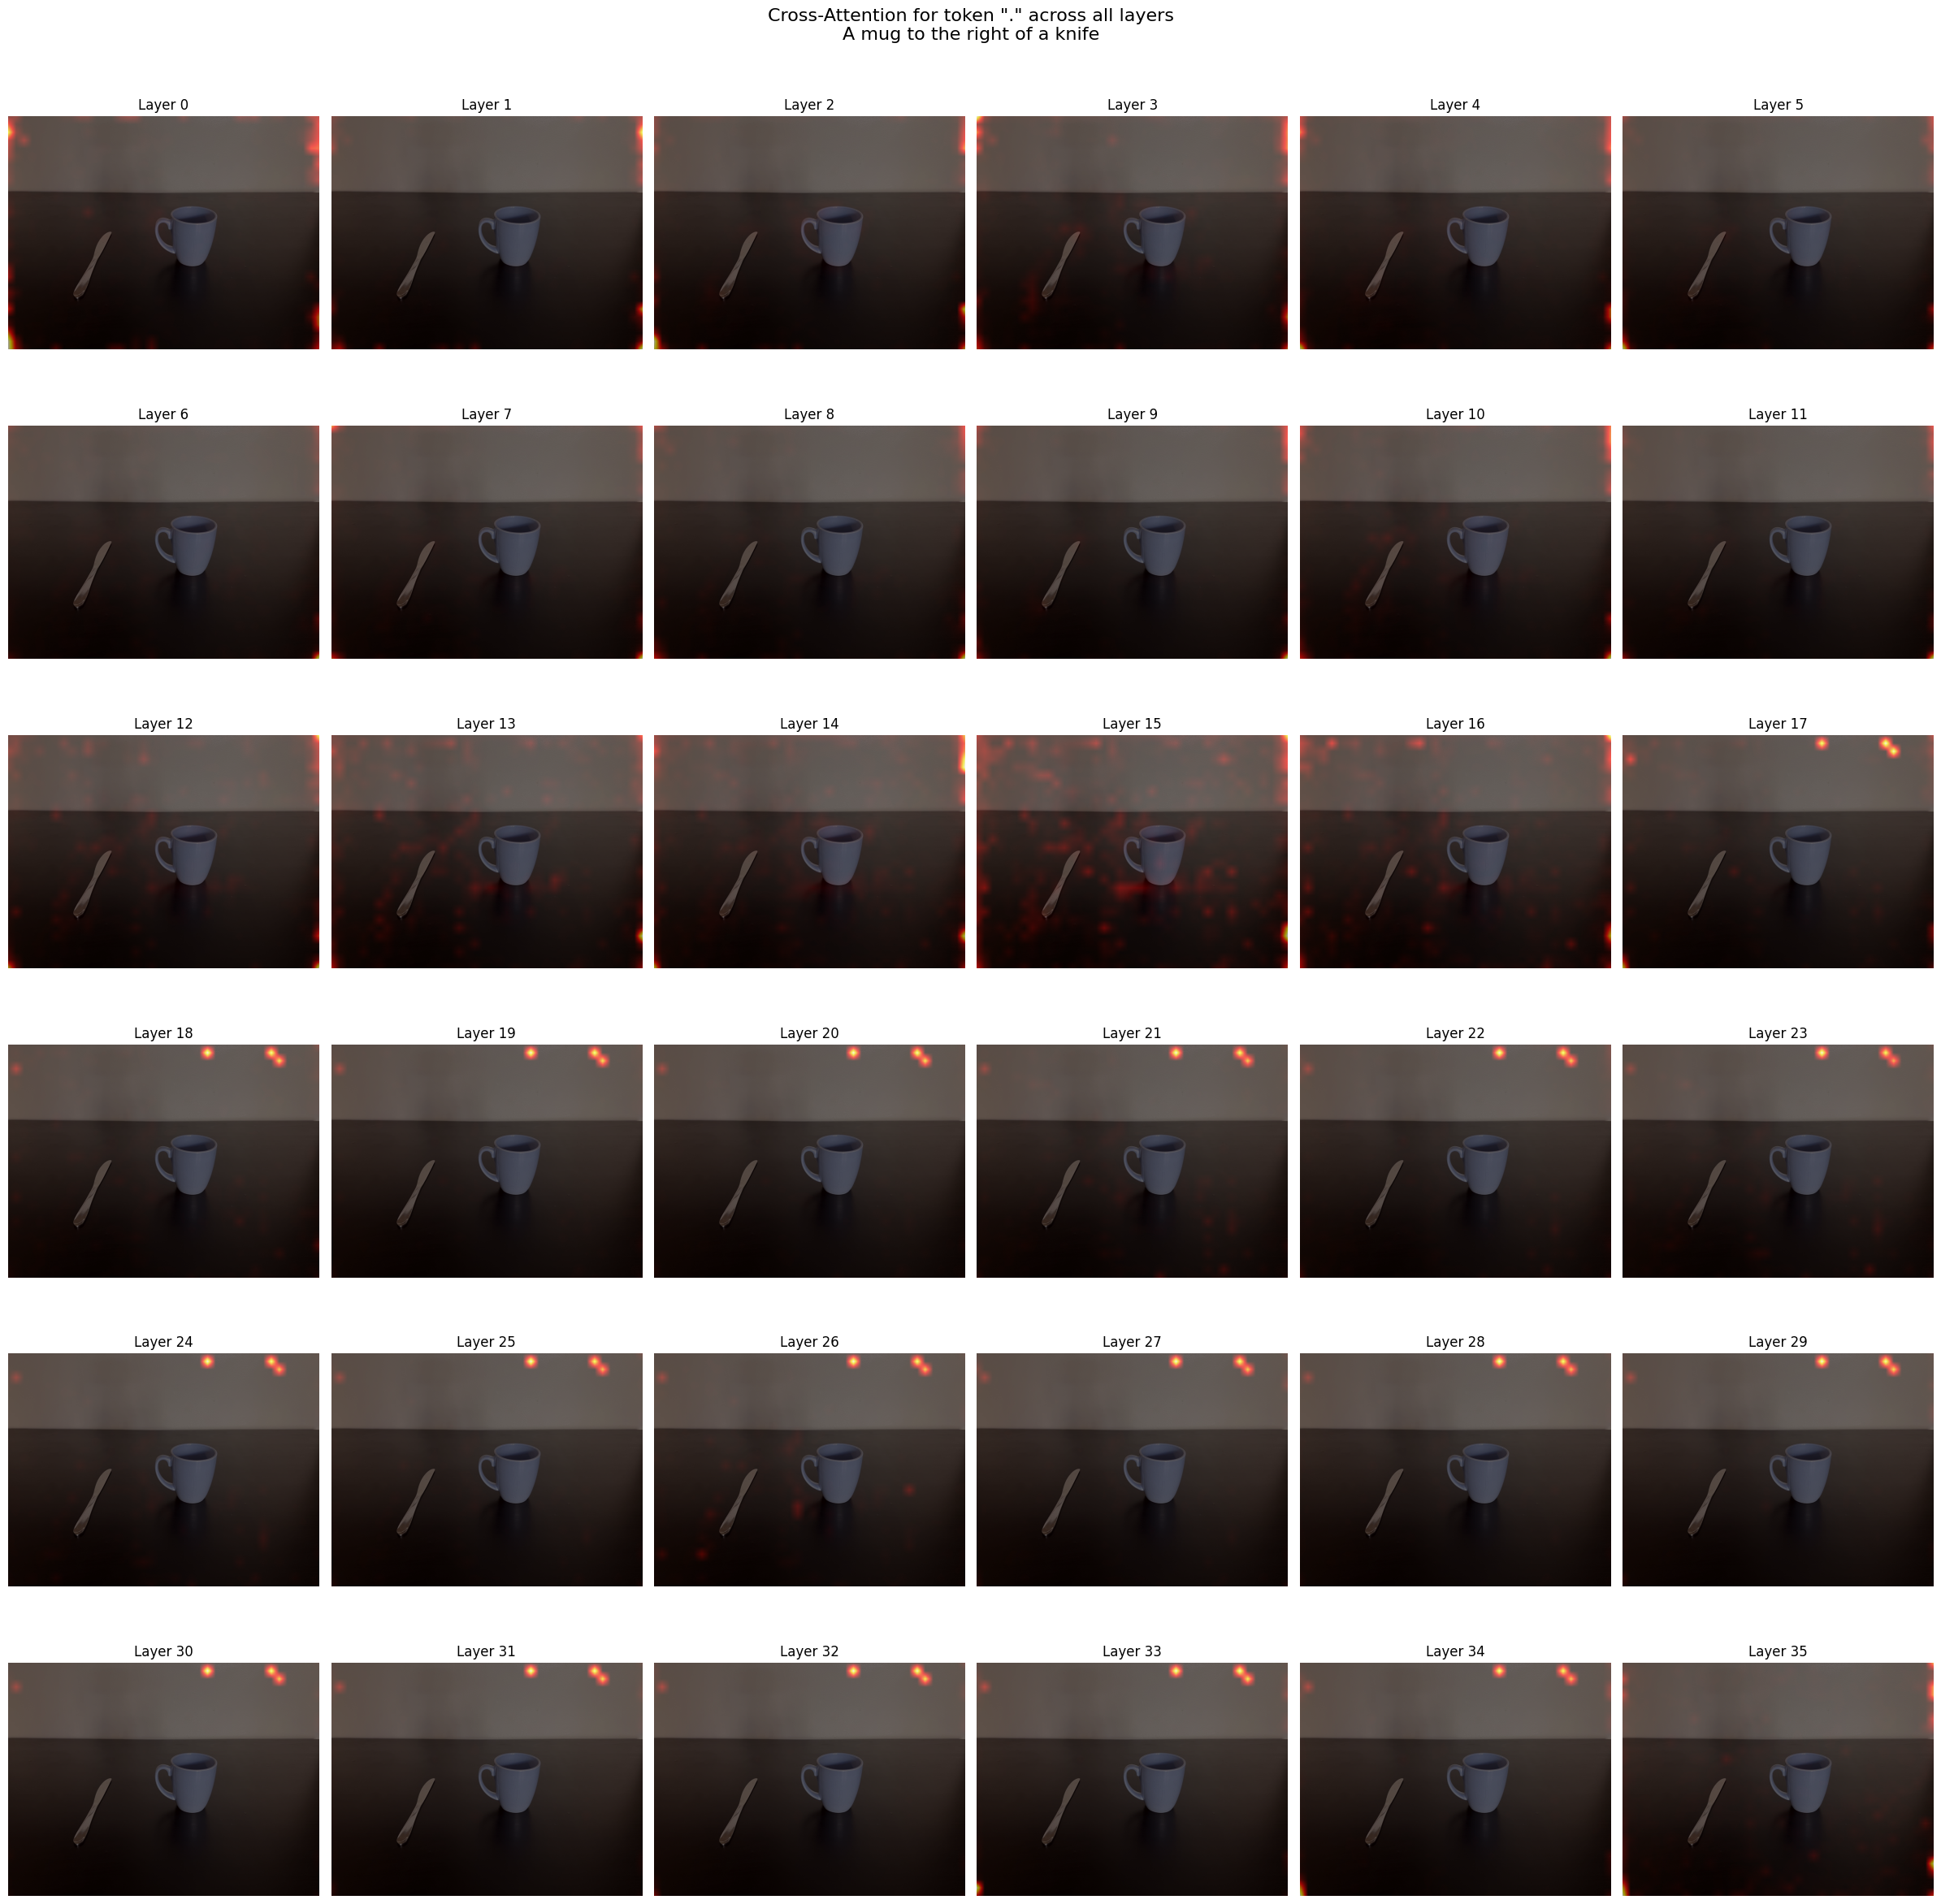


Comparing first, middle, and last layer attention:


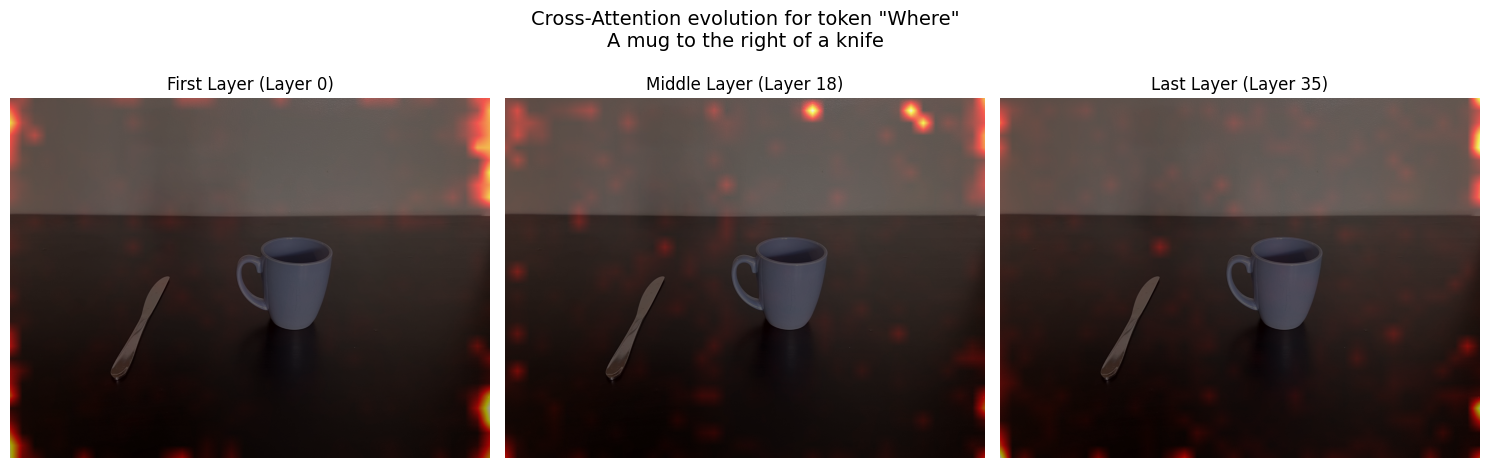

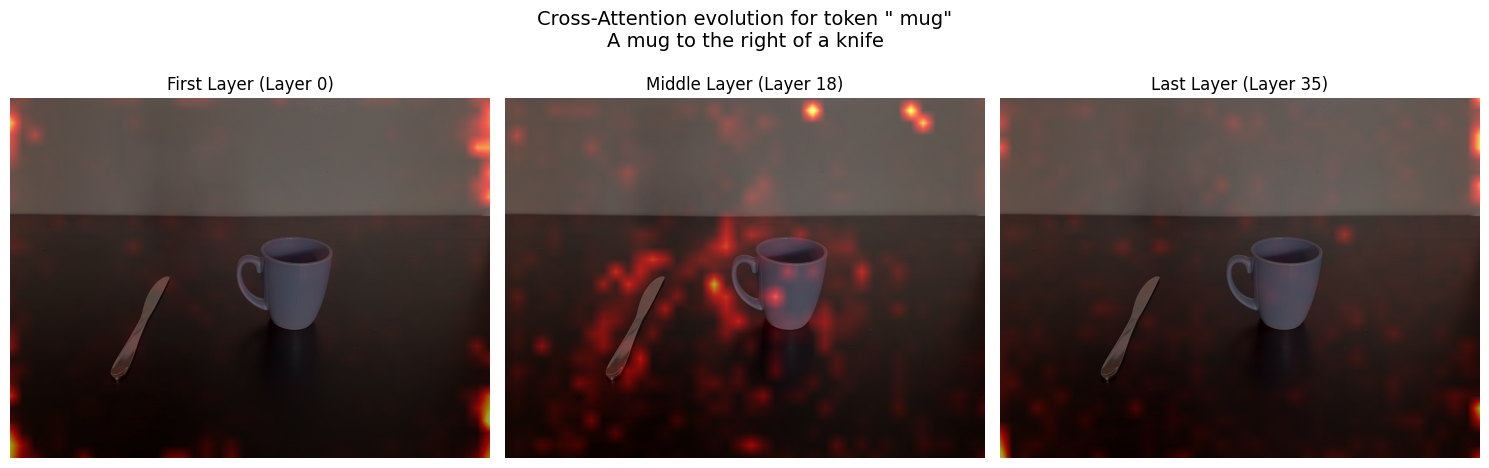

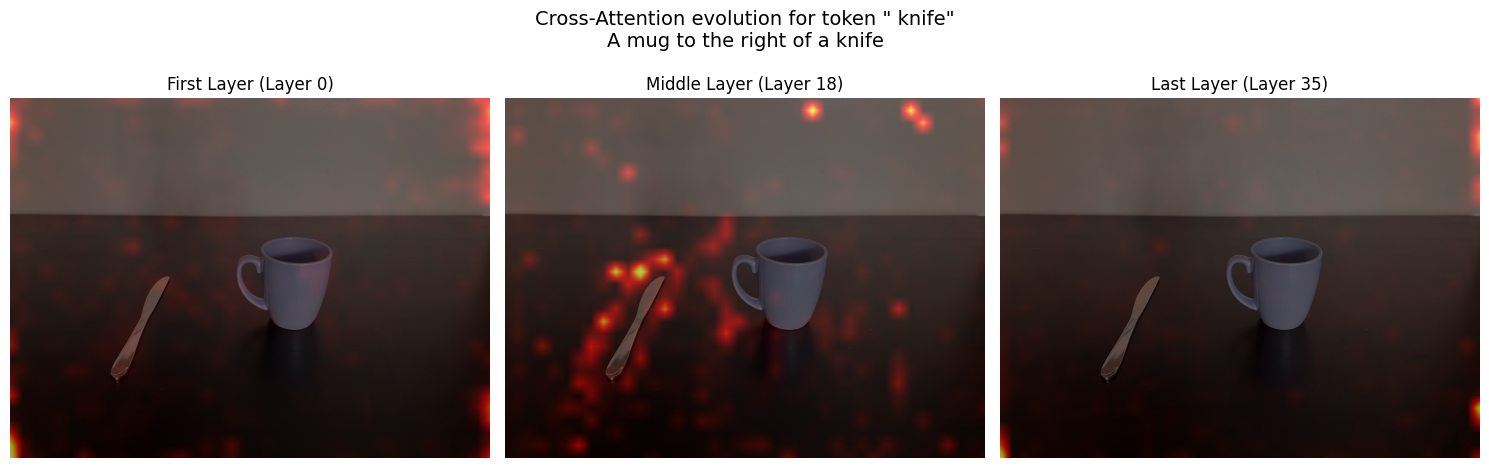

In [47]:

print(f"Total layers with attention: {len(attentions)}")

# Store cross-attention from all layers
all_cross_attn = []

for layer_idx, layer_attn in enumerate(attentions):
  # Get attention for this layer
  # Average over heads
  avg_attn = layer_attn[0].mean(0)  # [seq, seq]

  # Extract cross-attention: text tokens → image tokens
  text_start_idx = vision_end_idx + 1
  cross_attn_layer = avg_attn[text_start_idx:, vision_start_idx+1:vision_end_idx]

  all_cross_attn.append(cross_attn_layer)

  print(f"Layer {layer_idx}: cross-attention shape {cross_attn_layer.shape}")

# Get text tokens for labeling
text_tokens = tokens_list[text_start_idx:]
print(f"\nText tokens: {text_tokens[:20]}...")

# === Plot attention across all layers for a specific token ===
# Example: visualize "left" token across all layers
token_of_interest = "."  # Change this to any token you want
token_idx = None
for i, token in enumerate(text_tokens):
  if token_of_interest in token.lower():
      token_idx = i
      break

if token_idx is not None:
  print(f"\nVisualizing token '{text_tokens[token_idx]}' (index {token_idx}) across all layers")

  # Create grid of plots
  n_layers = len(all_cross_attn)
  n_cols = 6  # 6 layers per row
  n_rows = (n_layers + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
  axes = axes.flatten() if n_layers > 1 else [axes]

  for layer_idx, cross_attn_layer in enumerate(all_cross_attn):
      token_attn = cross_attn_layer[token_idx]  # [num_image_patches]

      # Reshape to 2D grid
      attn_grid = token_attn.cpu().float().reshape(grid_height, grid_width).numpy()

      # Normalize
      attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min() + 1e-8)

      # Resize to image size
      from scipy.ndimage import zoom
      img_array = np.array(image)
      zoom_factor = (img_array.shape[0] / grid_height, img_array.shape[1] / grid_width)
      attn_resized = zoom(attn_grid, zoom_factor, order=1)

      # Plot
      axes[layer_idx].imshow(img_array)
      axes[layer_idx].imshow(attn_resized, cmap='hot', alpha=0.6)
      axes[layer_idx].set_title(f'Layer {layer_idx}')
      axes[layer_idx].axis('off')

  # Hide unused subplots
  for idx in range(n_layers, len(axes)):
      axes[idx].axis('off')

  plt.suptitle(f'Cross-Attention for token "{text_tokens[token_idx]}" across all layers\n{caption}',
               fontsize=16, y=1.0)
  plt.tight_layout()
  plt.show()

# === Compare first, middle, and last layer ===
print("\nComparing first, middle, and last layer attention:")
comparison_layers = [0, len(all_cross_attn)//2, -1]
layer_names = ['First Layer', 'Middle Layer', 'Last Layer']

# Find indices of interesting tokens
spatial_words = ['left', 'right', 'front', 'behind', 'where']
object_words = [object1.lower(), object2.lower()]
interesting_words = spatial_words + object_words

interesting_indices = []
interesting_labels = []

for i, token in enumerate(text_tokens):
  token_clean = token.strip().lower()
  for word in interesting_words:
      if word in token_clean:
          interesting_indices.append(i)
          interesting_labels.append(f"{token}")
          break

if len(interesting_indices) > 0:
  # Plot for each interesting token
  for token_idx, token_label in zip(interesting_indices[:3], interesting_labels[:3]):  # First 3 tokens
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))

      for plot_idx, (layer_idx, layer_name) in enumerate(zip(comparison_layers, layer_names)):
          cross_attn_layer = all_cross_attn[layer_idx]
          token_attn = cross_attn_layer[token_idx]

          # Reshape and normalize
          attn_grid = token_attn.cpu().float().reshape(grid_height, grid_width).numpy()
          attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min() + 1e-8)

          # Resize
          img_array = np.array(image)
          zoom_factor = (img_array.shape[0] / grid_height, img_array.shape[1] / grid_width)
          attn_resized = zoom(attn_grid, zoom_factor, order=1)

          # Plot
          axes[plot_idx].imshow(img_array)
          axes[plot_idx].imshow(attn_resized, cmap='hot', alpha=0.6)
          axes[plot_idx].set_title(f'{layer_name} (Layer {layer_idx if layer_idx >= 0 else len(all_cross_attn)+layer_idx})')
          axes[plot_idx].axis('off')

      plt.suptitle(f'Cross-Attention evolution for token "{token_label}"\n{caption}', fontsize=14)
      plt.tight_layout()
      plt.show()

# Store the last layer as before for other cells
cross_attn = all_cross_attn[-1]

In [17]:
# Extract attention patterns for sample

In [49]:
import random
import torch
import pickle
from pathlib import Path

# Load dataset
dataset = get_controlled_images_a(
  image_preprocess=None,
  download=False,
  root_dir='/leonardo_work/EUHPC_D27_102/compmech/whatsup_vlms_data'
)

print(f"Dataset size: {len(dataset)}")

# Get several samples
sample_indices = random.sample(range(0, len(dataset)), 3)
samples = {i: dataset[i] for i in sample_indices}

# Process each sample
outputs_to_save = []
for dataset_idx, sample in samples.items():  # Changed: iterate over dict items
  print(f"\n{'='*50}")
  print(f"SAMPLE - Dataset Index: {dataset_idx}")
  print(f"{'='*50}")

  # Extract caption and objects
  caption = sample['caption_options'][0]
  words = caption.split()
  object1 = words[1]  # Second word
  object2 = words[-1]  # Last word

  # Get image
  image = sample['image_options'][0]

  # Create question
  question = f"Where is the {object1} in relation to the {object2}? Answer with left, right, front or behind."
  print(f"Caption: {caption}")
  print(f"Object 1: {object1}")
  print(f"Object 2: {object2}")
  print(f"Question: {question}")

  # Prepare messages in Qwen format
  messages = [
      {
          "role": "user",
          "content": [
              {"type": "image", "image": image},
              {"type": "text", "text": question},
          ],
      }
  ]

  # Apply chat template
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  print(f"\nFormatted prompt (first 200 chars):\n{text[:200]}...")

  # Process inputs
  inputs = processor(
      text=[text],
      images=[image],
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to(model.device)

  print(f"Input shape: {inputs['input_ids'].shape}")
  print(f"Total tokens: {inputs['input_ids'].shape[1]}")

  # Decode tokens to see the sequence
  tokens = processor.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
  print(f"\nFirst 20 tokens: {tokens[:20]}")
  print(f"Last 20 tokens: {tokens[-20:]}")

  # Forward pass with attention
  with torch.no_grad():
      outputs = model(
          **inputs,
          output_attentions=True,
          return_dict=True
      )

  print(f"Output keys: {outputs.keys()}")

  # Move outputs to CPU and prepare for saving
  sample_data = {
      'dataset_index': dataset_idx,  # Changed: use the actual dataset index
      'caption': caption,
      'object1': object1,
      'object2': object2,
      'question': question,
      'input_ids': inputs['input_ids'].cpu(),
      'attention_mask': inputs['attention_mask'].cpu(),
      'logits': outputs.logits.cpu(),
      'attentions': tuple(
          tuple(layer_attn.cpu() for layer_attn in layer) if isinstance(layer, tuple)
          else layer.cpu()
          for layer in outputs.attentions
      ),
  }

  # Add other output fields if they exist
  if hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
      sample_data['hidden_states'] = tuple(h.cpu() for h in outputs.hidden_states)

  outputs_to_save.append(sample_data)
  print(f"Saved output for dataset index {dataset_idx}")

# Save to disk
output_dir = Path('saved_outputs')
output_dir.mkdir(exist_ok=True)

# Option 1: Save as pickle (recommended for complex structures)
output_path = output_dir / 'model_outputs_a.pkl'
with open(output_path, 'wb') as f:
  pickle.dump(outputs_to_save, f)
print(f"\nSaved {len(outputs_to_save)} samples to {output_path}")

# Print summary
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
for data in outputs_to_save:
  print(f"Dataset Index {data['dataset_index']}:")
  print(f"  - Question: {data['question']}")
  print(f"  - Logits shape: {data['logits'].shape}")
  print(f"  - Num attention layers: {len(data['attentions'])}")

Dataset size: 412

SAMPLE - Dataset Index: 373
Caption: A shoes under a chair
Object 1: shoes
Object 2: chair
Question: Where is the shoes in relation to the chair? Answer with left, right, front or behind.

Formatted prompt (first 200 chars):
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Where is the shoes in relation to the chair? Answer with left, right, front or behind.<|im_end|>
<|im_start|>assistant
...
Input shape: torch.Size([1, 1230])
Total tokens: 1230

First 20 tokens: ['<|im_start|>', 'user', 'Ċ', '<|vision_start|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>', '<|image_pad|>']
Last 20 tokens: ['Ġrelation', 'Ġto', 'Ġthe', 'Ġchair', '?', 'ĠAnswer', 'Ġwith', 'Ġleft', ',', 'Ġright', ',', 'Ġfront', 'Ġor', 'Ġbehind', '.', '<|im_end|>', 'Ċ', '<|im_start|>', 'a